This notebook will optimize the hyperparameters of the Random Forest Classifier model, using an informed search method.  
I will be using the Hyperopt module for this task.  
Hyperopt performs a Bayesian search for the best hyperparameters, given a range of values.  
I will start with a broad range, then analyze the results of Hyperopt's choices.  
The range of hyperparameter values can be narrowed to perform another search for a better model.  
This process can be iterated, converging on the optimal model for the data.  
Once the hyperparameters have been selected, I will observe how the model performs on the holdout test data.

In [1]:
# set cell display width
from IPython.display import display, HTML, display_html
display(HTML('<style>.container { width: 930px !important; }</style>'))

In [2]:
# import ML tools
import numpy as np
import pandas as pd
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from functools import partial
import pickle
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope as ho_scope
from collections import defaultdict
from itertools import product

In [3]:
# import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

Use "my_big_pallette.colors(<index>)" as color attribute for Seaborn plots.
This is your color palette...


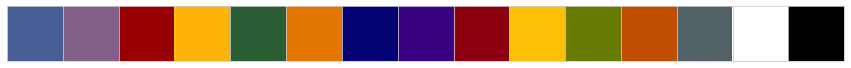

In [4]:
# import and set custom palette module
import my_big_palette as mp
sns.set_palette(sns.color_palette(mp.my_palette))

In [5]:
# free autocomplete from Jedi mind control
%config Completer.use_jedi = False

> **IMPORT DATA**

In [6]:
# read in and observe data
df = pd.read_json('../data/author_docs.json')
df

,rank,titles,tokens,docs
maxwellhill,top,['Chinese Premier accuses Dalai Lama of master...,"[chinese, premier, accuse, dalai, lama, master...",chinese premier accuse dalai lama mastermind r...
anutensil,top,"['Top 10 discoveries of 2009', 'Mystery behind...","[discovery, mystery, make, stradivarius, speci...",discovery mystery make stradivarius special co...
Libertatea,top,['Life inside the Ecuadorian embassy with Wiki...,"[life, inside, ecuadorian, embassy, wikileaks,...",life inside ecuadorian embassy wikileaks found...
DoremusJessup,top,['Human Rights Watch claims $32 billion missin...,"[human, rights, watch, claim, billion, miss, a...",human rights watch claim billion miss angola a...
Wagamaga,top,['The government wants penalties including pot...,"[government, want, penalty, include, potential...",government want penalty include potential jail...
...,...,...,...,...
davitruiz,bottom,['Madrid train strike the day before holiday w...,"[madrid, train, strike, day, holiday, weekend,...",madrid train strike day holiday weekend ley mo...
davie18,bottom,['Remember that letter to Sainsbury s where a ...,"[remember, letter, sainsbury, little, girl, sa...",remember letter sainsbury little girl say tige...
davidstern350,bottom,['UOSSM Urges the International Organizations ...,"[uossm, urges, international, organizations, e...",uossm urges international organizations extend...
davidmj85,bottom,['NSW bushfires: live updates October 23'],"[nsw, bushfires, live, update, october]",nsw bushfires live update october


> **GENERATE TF-IDF**

I'll vectorize the test data and generate TF-IDF values for the authors, as before.

In [7]:
# instantiate Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer
vectorizer = TfidfVectorizer()

In [8]:
# compute word count, IDF, and TF-IDF values
tf_idf_vectors = vectorizer.fit_transform(df['docs'])

In [9]:
# separate data into features and target
X = tf_idf_vectors
y = df['rank']

In [10]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27)

> **INFORMED HYPERPARAMETER SEARCH**

I will reuse some parts of the function that I created in the model selection notebook.

In [11]:
def get_cv_results(features, target, params={}, cv=3):
    """Returns CV test recall scores and confusion matrix for the target class"""
    
    # create lists to hold confusion matrix data
    cm_train_lst = []
    cm_test_lst = []

    # instantiate KFold object for custom CV
    folds = KFold(n_splits=cv, random_state=27, shuffle=True)

    # split data and run folds called
    for train_index, test_index in folds.split(features, target):
        # create training and test folds
        train_features = features[train_index]
        train_target = target.iloc[train_index]
        test_features = features[test_index]
        test_target = target.iloc[test_index]

        # instantiate and train Random Forest Classifier model
        model = RandomForestClassifier(**params, n_jobs=-1, random_state=27)
        model.fit(train_features, train_target)

        # get model predictions
        train_preds = model.predict(train_features)
        test_preds = model.predict(test_features)

        # get confusion matrices
        label_mapper = {0: 'bottom', 1: 'middle', 2: 'top'}
        cm_train_df = pd.DataFrame(
            confusion_matrix(train_target, train_preds)).rename(
            index=label_mapper, columns=label_mapper)
        cm_test_df = pd.DataFrame(
            confusion_matrix(test_target, test_preds)).rename(
            index=label_mapper, columns=label_mapper)
        # store confusion matrices
        cm_train_lst.append(cm_train_df)
        cm_test_lst.append(cm_test_df)

    # combine confusion matrix data from all folds into single DataFrame
    cm_train_df = pd.concat(cm_train_lst)
    cm_test_df = pd.concat(cm_test_lst)
    # sum confusion matrix data over all folds
    cm_train_df = cm_train_df.groupby(cm_train_df.index).sum().astype(int)
    cm_test_df = cm_test_df.groupby(cm_test_df.index).sum().astype(int)

    # calculate weighted average of recall scores for 'top' class
    recall_train = cm_train_df.iloc[2, 2] / cm_train_df.iloc[2].sum()
    recall_test = cm_test_df.iloc[2, 2] / cm_test_df.iloc[2].sum()
    
    # store recall scores in dict
    cv_results = {'train_score':recall_train, 'test_score':recall_test}
    
    return cv_results, cm_test_df

Here, I need to create an objective function that returns the loss values to direct Hyperopt's search.  
Note that the loss for Hyperopt gets minimized, while I am maximizing the test recall.  
I have modified the loss function to reflect this.  
This is where any other data can be collected from the search, as well.

In [12]:
def objective(params, features, target, cv=3):
    """Returns CV results for Random Forest Classifier model"""
    # enable iteration marker to be GLOBAL variable
    global global_iterations
    # update marker
    global_iterations += 1
    # get all scores from 10 fold cross-validation
    cv_results = get_cv_results(features, target, params, cv)[0]
    # get average scores from 10 fold cross-validation
    test_mean = cv_results['test_score']
    train_mean = cv_results['train_score']
    # get loss function to minimize
    loss_func = 1 - test_mean

    return {
        'trial': global_trials, 
        'batch': global_batches, 
        'iteration': global_iterations, 
        'loss': loss_func, 
        'test_score': test_mean, 
        'train_score': train_mean, 
        'params': params, 
        'status': STATUS_OK
    }

Now, I need to create a function that runs the searches, or Hyperopt trials.  
This function has early stopping parameters that can be set before the search.

In [13]:
def run_trial_batches(features, target, hp_space, trials, cv=3, 
                      batch_size=10, max_batches=10):
    """Runs informed search trials in batches with a cap on the number of batches"""
    # enable trial marker to be GLOBAL variable (allows continuation of existing trial)
    global global_trials
    global_trials +=1
    # check for newly initialized trials object
    if not trials.losses():
        # initialize best loss and number of iterations for new trials object
        last_best = 0
        last_iters = 0
    else:
        # initialize best loss and number of iterations from imported trials object
        last_best = trials.best_trial['result']['loss']
        last_iters = len(trials.losses())
    # initialize best loss for batch
    new_best = 0
    # initialize early stop flag
    early_stop = 'GO!'
    # run optimization search over all batches
    for batch in range(max_batches):
        # check for early stop
        if early_stop == 'GO!':
            # enable batch marker to be GLOBAL variable
            global global_batches
            # update trials batch counter
            global_batches += 1
            # set iterations argument for maximum evaluations parameter of fmin function
            n_iters = batch_size * (batch + 1) + last_iters
            # use partial function to lower number of trials used to initialize warm start
            fmin_suggest = partial(tpe.suggest, n_startup_jobs=1)
            # use partial function to enable selection of trials data
            fmin_objective = partial(
                objective, features=features, target=target, cv=cv)
            # run one batch
            fmin(fn=fmin_objective, space=hp_space, max_evals=n_iters, trials=trials, 
                 algo=fmin_suggest, rstate=np.random.RandomState(27))
            # save updated results to M.2 (stores most recent trials object)
            pickle.dump(trials, open(
                '../data/rfc_hyperopt_trials/rfc_trials_last.pkl', 'wb'))
            # capture current optimal loss
            new_best = trials.best_trial['result']['loss']
            # check that batch optimized
            if last_best == new_best:
                early_stop = 'STOP!'
            last_best = new_best

> **TRIALS 1**

In [14]:
# instantiate trials object for Random Forest Classifier optimization
rfc_trials_1 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [15]:
# create informed search space  
hp_space = {
    'criterion': hp.choice('criterion', ['gini', 'entropy']), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 1, 21)), 
    'max_samples': hp.uniform('max_samples', 0.1, 1), 
    'min_samples_leaf': ho_scope.int(hp.uniform('min_samples_leaf', 1, 7)), 
    'min_samples_split': ho_scope.int(hp.uniform('min_samples_split', 2, 8)), 
    'n_estimators': ho_scope.int(hp.uniform('n_estimators', 5, 200))
}
# call optimization function
run_trial_batches(X_train, y_train, hp_space, rfc_trials_1, cv=10)
# save trials object
pickle.dump(rfc_trials_1, open(
    '../data/rfc_hyperopt_trials/rfc_trials_1.pkl', 'wb'))

100%|██████████| 30/30 [02:54<00:00, 17.43s/trial, best loss: 0.5686274509803921]


The search went for 30 iterations, each performing a 10 fold cross validation.

In [16]:
def plot_param_search(trials):
    """Plot iterations of optimization search for hyperparmeters"""
    # establish figure height (each hyperparameter + one optimization plot)
    num_subplots = len(trials.idxs.keys()) + 1
    fig_height = num_subplots * 4
    # establish subplots
    fig, axes = plt.subplots(nrows=num_subplots, figsize=(12, fig_height))
    # plot parameters of optimization run
    count = 1
    for key in trials.idxs:
        plt.subplot(num_subplots, 1, count)
        
        # get number of trials in run
        n_iters = len(trials.losses())
        # get iteration of optimal objective loss
        best_iter = trials.best_trial['tid'] + 1        
        # get value for hyperparameter of best model
        best_val = trials.argmin[key]
        # get list of hyperparameter values
        vals_lst = trials.vals[key]
        
        # adjust values for data type
        if key in ['max_depth', 'min_samples_leaf', 'min_samples_split', 'n_estimators']:
            best_val = int(best_val)
            vals_lst = list(map(int, vals_lst))
        else:
            best_val = round(best_val, 6)

        # plot hyperparameters for optimization run
        plt.plot(range(1, len(trials.results) + 1), vals_lst, 
                 marker='o', color=mp.colors(4), alpha=0.8)        
        # mark off optimal hyperparameter value
        plt.hlines(best_val, n_iters * -0.05, n_iters * 1.05, linestyles = '--', 
                   label='Optimal \n' + str(key) + ': \n' + '{:,}'.format(best_val), 
                   colors=mp.colors(2))
        # mark iteration of optimal objective loss at hyperparameter value
        plt.plot(best_iter, best_val, marker='*', ms=15, color=mp.colors(2))
        count += 1
        
        plt.ylabel(key, fontsize=18)
        
        plt.legend(bbox_to_anchor=(1.31, 0.5), loc=5, fontsize='x-large')

    plt.subplot(num_subplots, 1, count)
    
    # get optimal test loss value
    best_test_loss = trials.best_trial['result']['test_score']
    
    # plot test loss for optimization run
    sns.lineplot(x=range(1, n_iters + 1), 
                 y=[v['test_score'] for v in trials.results], 
                 marker='o', label='Test Loss')
    
    # mark off best test loss
    plt.hlines(best_test_loss, n_iters * -0.05, n_iters * 1.05, linestyles = '--', 
               colors='k')
    # mark iteration of optimal test loss
    plt.plot(best_iter, best_test_loss, marker='*', ms=15, color='k', 
             label='Test Error: \n' + '{:,.4f}'.format(best_test_loss))

    plt.xlabel('Iteration (Best Iteration: ' + str(best_iter) + ')', fontsize=15)
    plt.ylabel('Recall', fontsize=18)
    
    plt.legend(bbox_to_anchor=(1.33, 0.5), loc=5, fontsize='x-large', 
               title='Best Iteration', title_fontsize='x-large')
    plt.suptitle('Hyperparameter Optimization Sequence', y=0.93, fontsize=23)

The hyperparameter values chosen during the search are plotted, along with the test recall scores below.  
The values are shown for the best hyperparameter combination, as well.

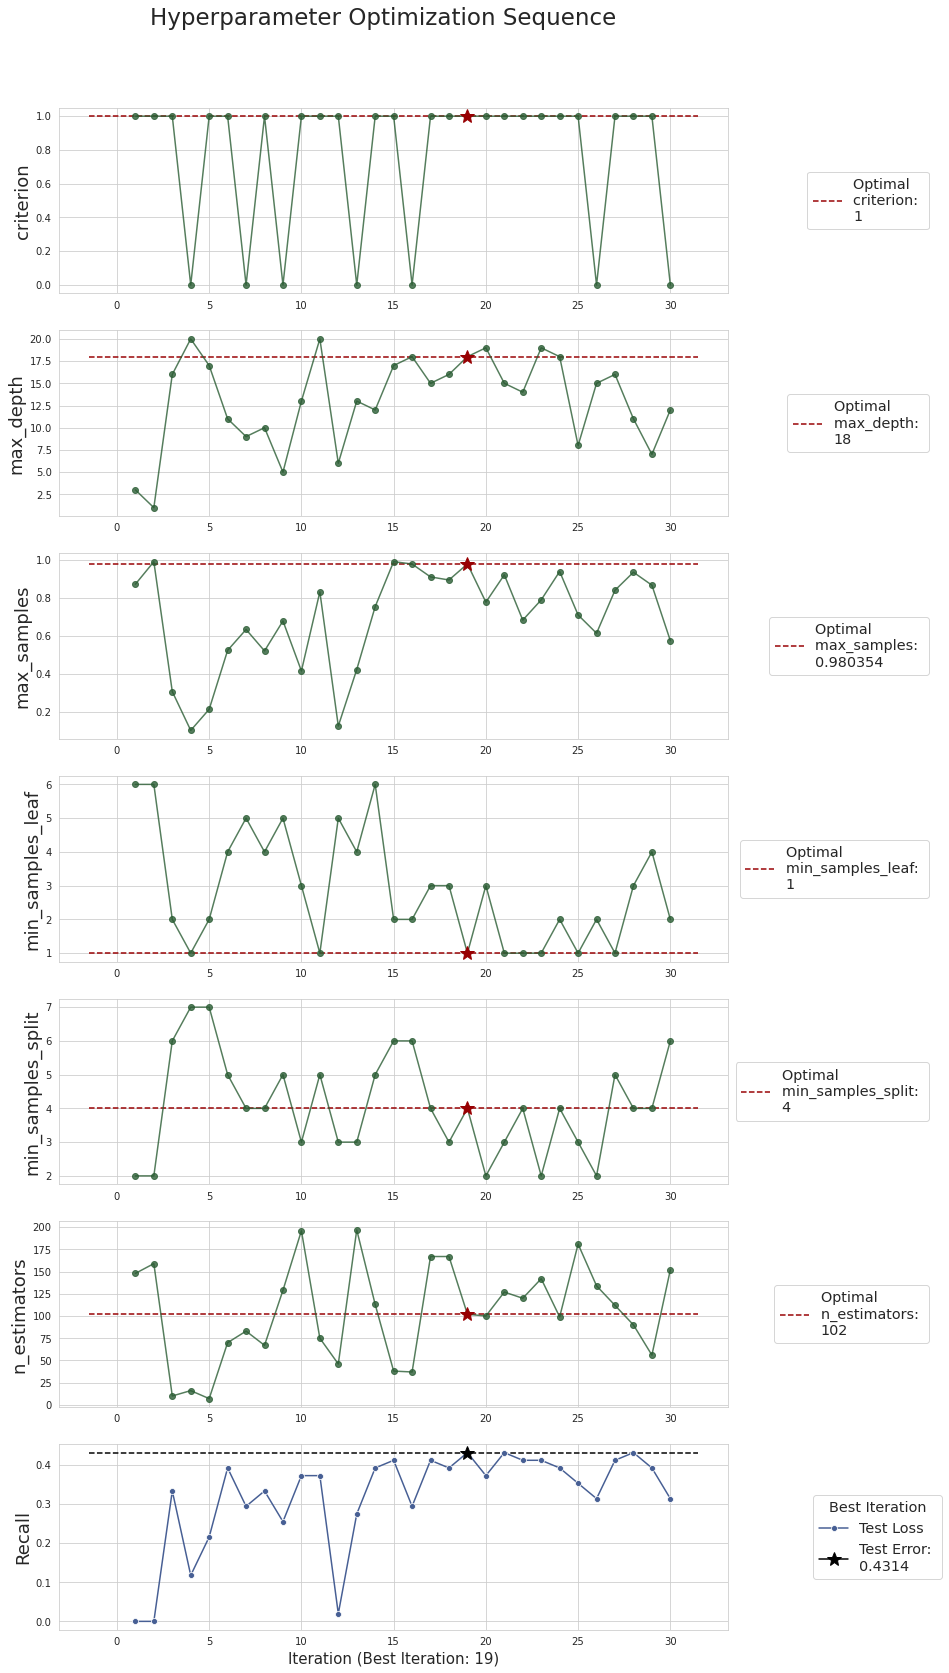

In [17]:
# plot informed search history
plot_param_search(rfc_trials_1)

In [18]:
def make_trials_df(trials):
    """Returns a DataFrame from results dict of objective function sorted by loss"""
    
    # convert dict to DataFrame
    trials_df = pd.DataFrame(trials.results)
    # extract nested parameter dicts to separate DataFrame
    params_df = pd.DataFrame(trials_df['params'].to_list())
    # combine DataFrames, clean up, and order by best loss
    trials_df = trials_df.drop(
        ['params', 'status', 'trial', 'batch', 'loss'], axis=1).join(
        params_df).sort_values('test_score', ascending=False).set_index('iteration')
    
    return trials_df

I'll show the hyperparameters from the top 10 models.

In [19]:
# get results DataFrame
trials_1_df = make_trials_df(rfc_trials_1)
trials_1_df.head(10)

,test_score,train_score,criterion,max_depth,max_samples,min_samples_leaf,min_samples_split,n_estimators
iteration,,,,,,,,
21,0.431373,1.000000,entropy,15,0.922948,1,3,127
28,0.431373,0.760349,entropy,11,0.936602,3,4,90
19,0.431373,1.000000,entropy,18,0.980354,1,4,102
15,0.411765,0.869281,entropy,17,0.992351,2,6,38
27,0.411765,0.980392,entropy,16,0.841549,1,5,112
17,0.411765,0.771242,entropy,15,0.911841,3,4,167
22,0.411765,0.949891,entropy,14,0.684250,1,4,120
23,0.411765,1.000000,entropy,19,0.790842,1,2,142
29,0.392157,0.612200,entropy,7,0.868317,4,4,56


In [20]:
def plot_one_param(trials, param, param_min=None, param_max=None):
    """Plots Recall vs. one hyperparameter with the option to limit the range"""
    df = make_trials_df(trials)
    # check to see if range needs to be altered
    if (param_min and param_max):
        df = df[(df[param] > param_min) & (df[param] < param_max)]        
    # plot hyperparameters for optimization run
    sns.regplot(x=param, y='test_score', data=df, 
        scatter_kws={'s': 10}, label='Test Loss')

    plt.xlabel(param, fontsize=14)
    plt.ylabel('Recall', fontsize=14)
    
    plt.legend(bbox_to_anchor=(1.25, 0.5), loc=5, fontsize='x-large')

In [21]:
def plot_recall(trials):
    """Plots Recall for all hyperparameters"""
    # establish figure height
    num_subplots = len(trials.idxs) - 1
    fig_height = num_subplots * 4
    # establish subplots
    fig, axes = plt.subplots(nrows=num_subplots, figsize=(12, fig_height))
    # plot hyperparameters of optimization run
    count = 1
    # remove binary hyperparameter
    new_trials = dict(trials.idxs)
    del(new_trials['criterion'])
    # get all hyperparameters in trials object
    for key in new_trials:
        plt.subplot(num_subplots, 1, count)
        # call hyperparameter plotting function
        plot_one_param(trials, key)
        
        plt.xlabel(key, fontsize=14, labelpad=10)
        plt.ylabel('Recall', fontsize=14)
        
        plt.legend(bbox_to_anchor=(1.25, 0.5), loc=5, fontsize='x-large')
        count += 1
        
    plt.suptitle('Hyperparameter Informed Search Results', 
                 y=1, fontsize=23)
    plt.tight_layout();

Here, I will show the distribution of recall scores with respect to each hyperparameter.  
Lines with large tilts show hyperparameters that need their ranges modified.  
This will reduce the amount the search is affected by its cold start.  
Note that the range of the max samples is at its upper limit.  
This line will always tilt, as long as the search is focused at the high values.

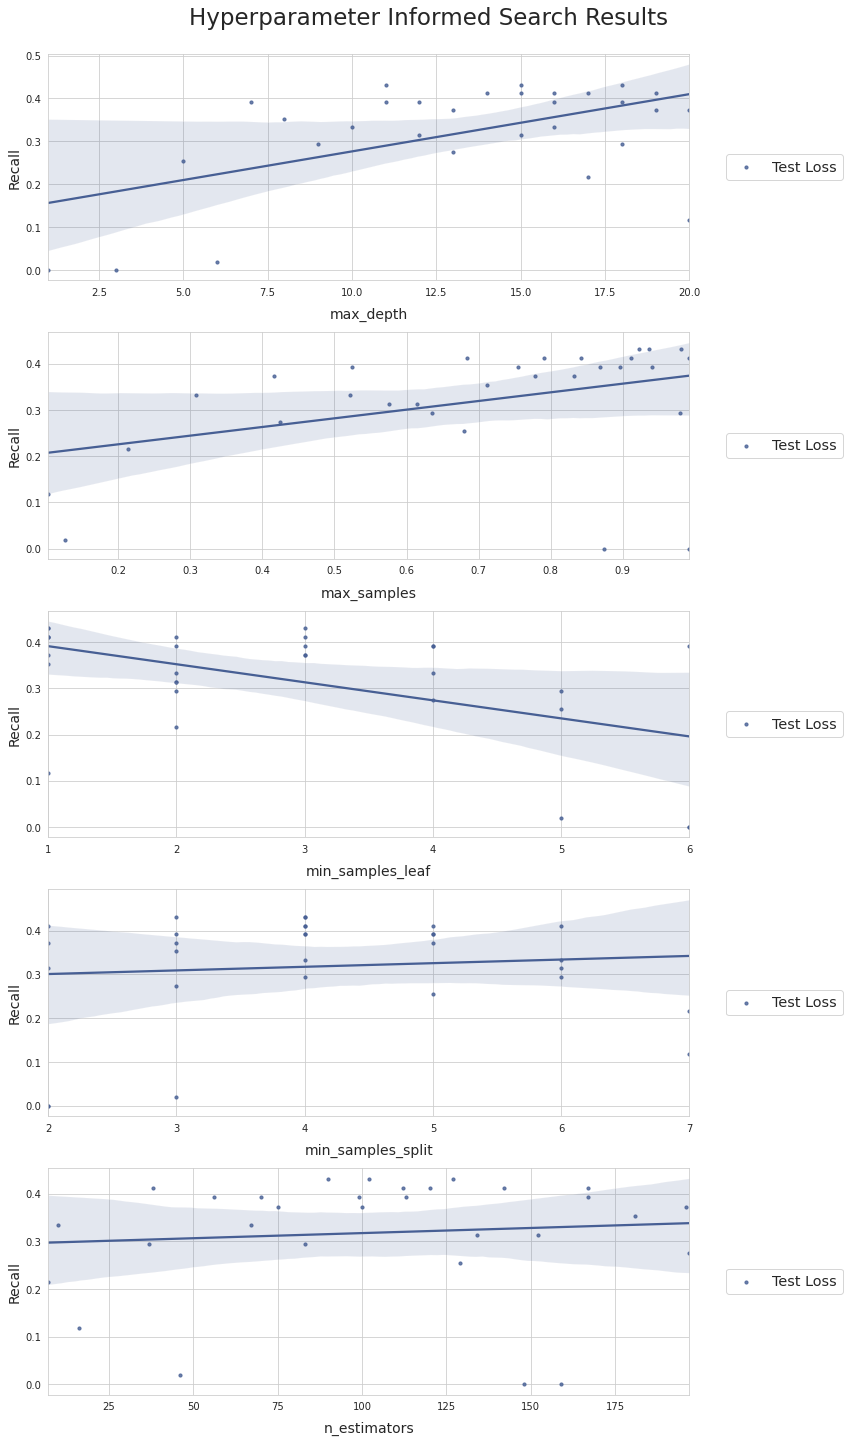

In [22]:
# plot hyperparameters vs. mean absolute errors
plot_recall(rfc_trials_1)

In [23]:
def plot_kde(trials_dict):
    """Plot range of hyperparameters for each trial given"""
    # create empty dict to hold DataFrames of trials parameters
    df_dict = {}
    # fill dict with each DataFrame
    for trial, num in trials_dict.items():
        # create default dict to sort values of hyperparameters
        param_dict = defaultdict(list)
        # extract iterations
        for d in trial.miscs:
            # sort values from iteration
            for key, val in d['vals'].items():
                param_dict[key].append(val[0])
            # store sorted hyperparameter values from each trial in DataFrame
            param_df = pd.DataFrame(param_dict).drop('criterion', axis=1)
        # add DataFrame to dict
        df_dict[num] = param_df
    # get maximum number of hyperparameters to establish subplots
    n_rows = max([len(x.columns) for x in df_dict.values()])
    fig_height = n_rows * 4
    fig, axes = plt.subplots(nrows=n_rows, figsize=(12, fig_height))
    # create empty dict to map hyperparameters to axes numbers
    axes_dict = {}
    ax_num = -1
    # sort hyperparameters out of DataFrames
    for num, df in df_dict.items():
        # get list of hyperparameters from DataFrame
        cols_lst = list(df.columns)
        # go through hyperparameters and plot
        for param in cols_lst:
            # build axes mapper
            if param not in list(axes_dict.keys()):
                ax_num += 1
                axes_dict[param] = ax_num
            # plot kernel density estimate for hyperparameter
            g = sns.kdeplot(df[param], label=num, 
                        ax=axes[axes_dict[param]])
            g.set_xlabel(param, fontsize=15)
            g.set_ylabel('Probability Density', fontsize=15)
            g.legend()

    plt.suptitle('Kernel Density Estimates for Different Tuning Ranges', fontsize=15)
    plt.subplots_adjust(top=0.95)

The final plot shows the density of the hyperparameters that were sampled in the search.  
An informed search will narrow its focus on values that produce better models.

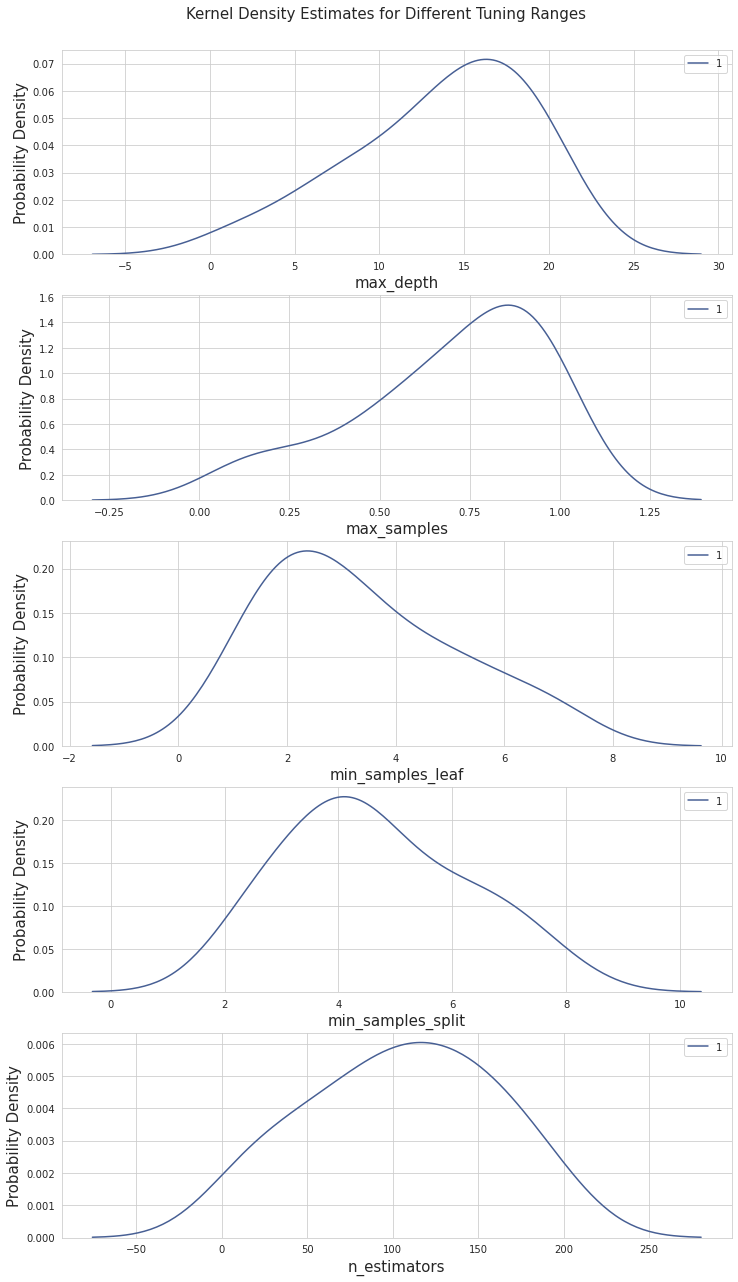

In [24]:
_dict = {rfc_trials_1: 1  
         }
# plot results from first trial
plot_kde(_dict)

I can see that the max depth range doesn't need to be as low as I had it.  
The same goes for the max samples.  
I can reduce the min samples leaf, just a bit.  
Also, the n estimators range can be narrowed.  
I'll make these modifications and observe the results.

> **TRIALS 2**

In [25]:
# instantiate trials object for Random Forest Classifier optimization
rfc_trials_2 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [26]:
# create informed search space  
hp_space = {
    'criterion': hp.choice('criterion', ['gini', 'entropy']), 
    'max_depth': ho_scope.int(hp.uniform('max_depth', 10, 21)), 
    'max_samples': hp.uniform('max_samples', 0.7, 1), 
    'min_samples_leaf': ho_scope.int(hp.uniform('min_samples_leaf', 1, 5)), 
    'min_samples_split': ho_scope.int(hp.uniform('min_samples_split', 2, 7)), 
    'n_estimators': ho_scope.int(hp.uniform('n_estimators', 30, 170))
}
# call optimization function
run_trial_batches(X_train, y_train, hp_space, rfc_trials_2, cv=10)
# save trials object
pickle.dump(rfc_trials_2, open(
    '../data/rfc_hyperopt_trials/rfc_trials_2.pkl', 'wb'))

100%|██████████| 30/30 [02:53<00:00, 17.38s/trial, best loss: 0.5686274509803921]


The best loss is the same as it was in the first search.

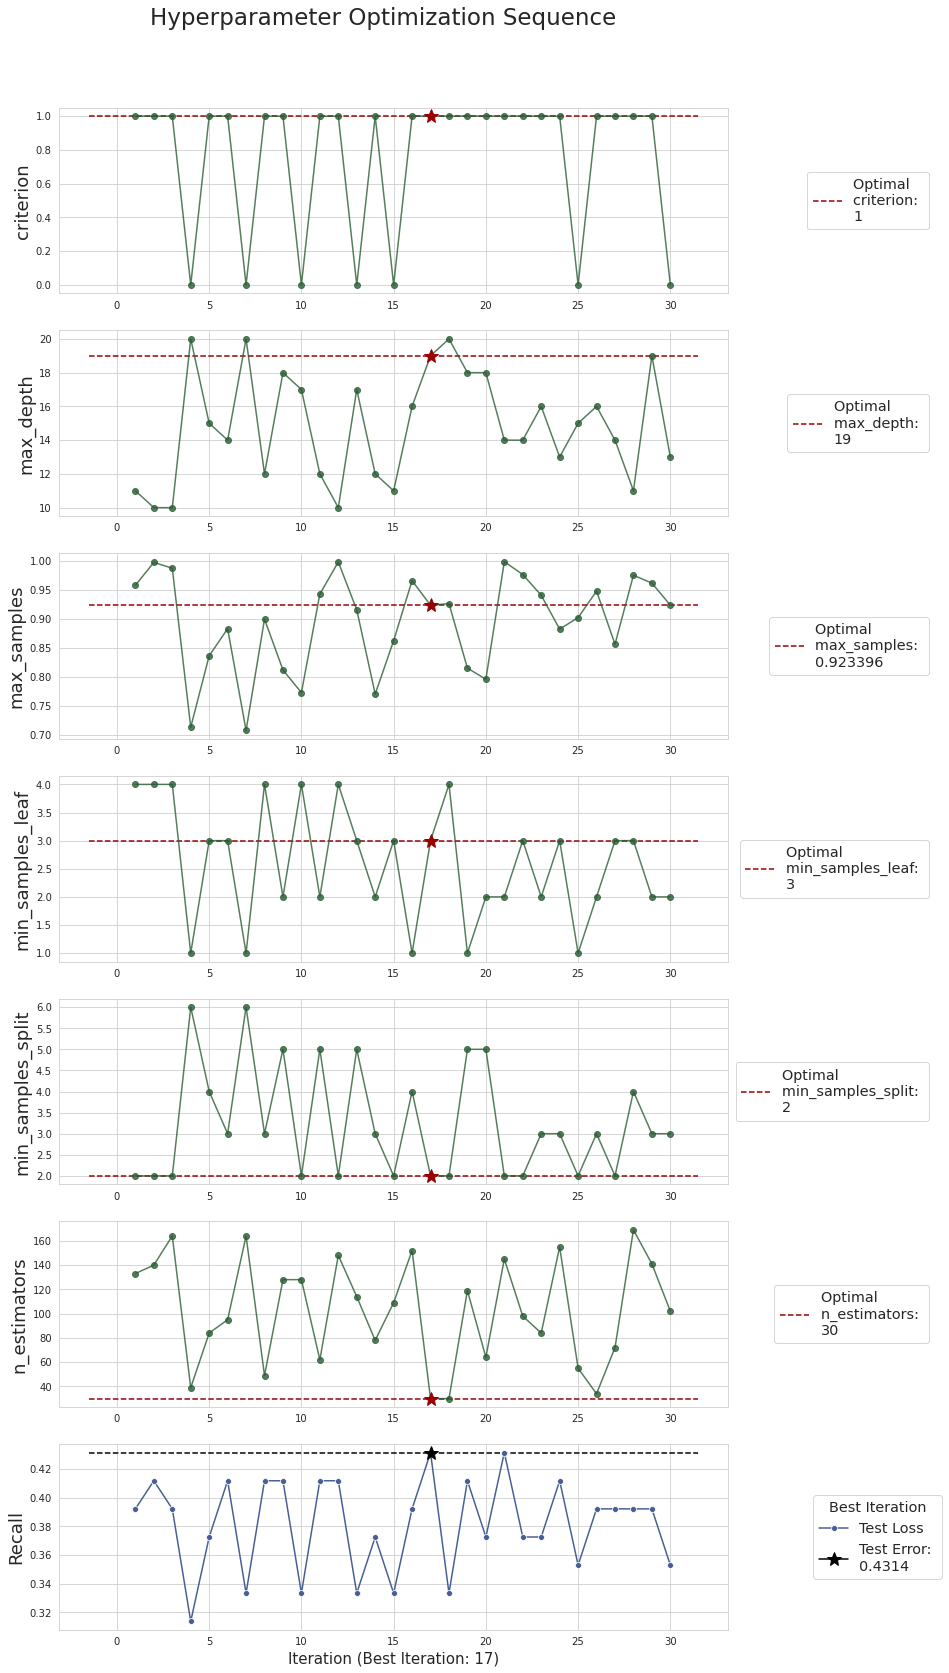

In [27]:
# plot informed search history
plot_param_search(rfc_trials_2)

In [28]:
# get results DataFrame
trials_2_df = make_trials_df(rfc_trials_2)
trials_2_df.head(10)

,test_score,train_score,criterion,max_depth,max_samples,min_samples_leaf,min_samples_split,n_estimators
iteration,,,,,,,,
21,0.431373,0.906318,entropy,14,0.998539,2,2,145
17,0.431373,0.773420,entropy,19,0.923396,3,2,30
2,0.411765,0.714597,entropy,10,0.997317,4,2,140
6,0.411765,0.747277,entropy,14,0.883059,3,3,95
8,0.411765,0.657952,entropy,12,0.899564,4,3,49
9,0.411765,0.814815,entropy,18,0.812021,2,5,128
24,0.411765,0.758170,entropy,13,0.882410,3,3,155
11,0.411765,0.867102,entropy,12,0.942739,2,5,62
12,0.411765,0.714597,entropy,10,0.997975,4,2,148


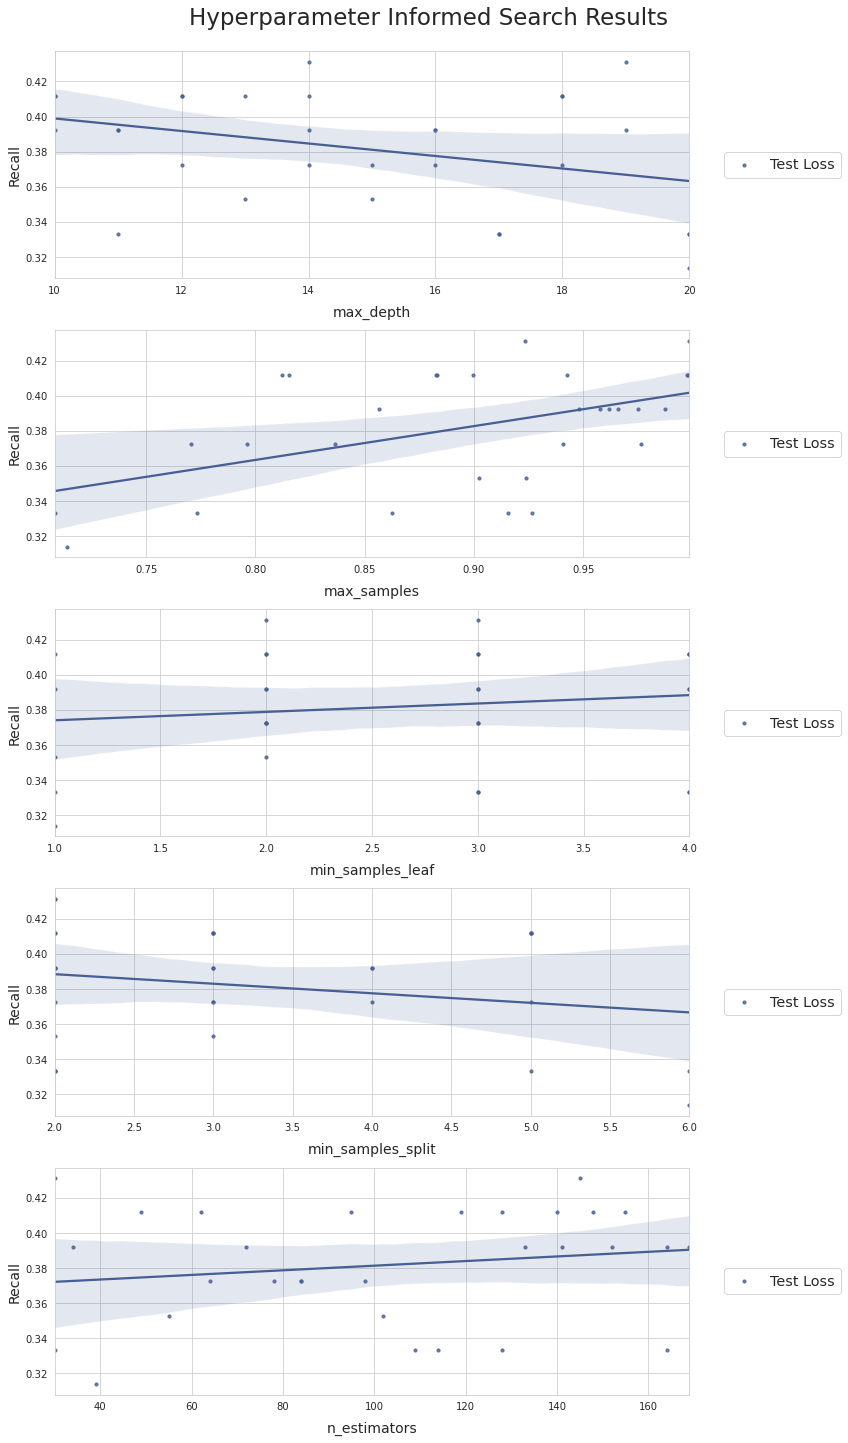

In [29]:
# plot hyperparameters vs. mean absolute errors
plot_recall(rfc_trials_2)

I can compare the distributions of the chosen hyperparameter values to observe any differences.

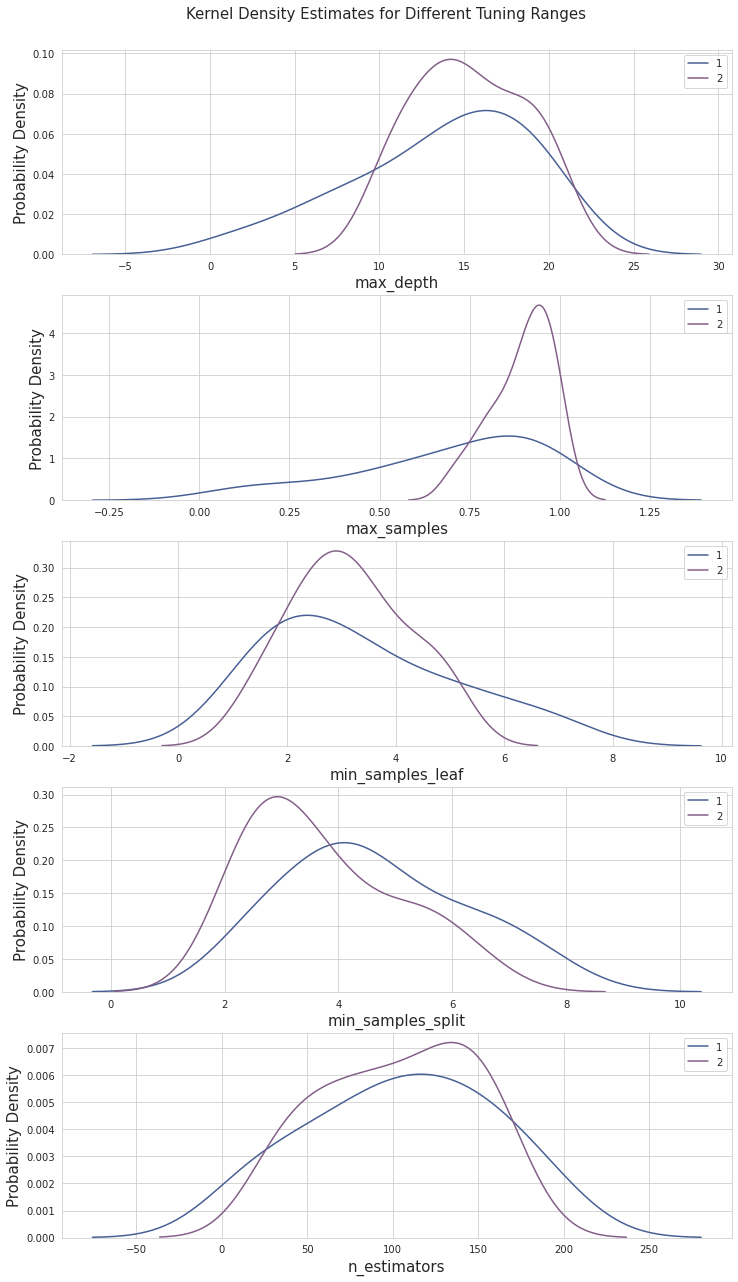

In [30]:
_dict = {rfc_trials_1: 1, 
         rfc_trials_2: 2  
         }
# plot results from both trials
plot_kde(_dict)

Aside from the max values hyperparameter, both searches are choosing similar vaules.  
More fine tuning may be attempted, but it is unlikely to produce better results.

> **FINAL RESULTS**

Now, I'll see how the optimized model performs on data it has not seen.

In [31]:
def print_final_results(features, target, trials, cv=3):
    """Print final test recall from best classifier"""
    # split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
    
    # get hyperparameters from trials object
    params = trials.best_trial['result']['params']
    
    # get test recall and confusion matrix from trained Random Forest Classifier
    cv_results, cm_test_df = get_cv_results(X_test, y_test, params, cv=cv)
    recall_test = cv_results['test_score']
    
    print(f'Final Test Data Recall: {recall_test:.3f}\n')
    for param, value in params.items():
        print(f'{param}: {value}')
    
    return cm_test_df

In [32]:
# get final results on holdout data
print_final_results(X, y, rfc_trials_2, cv=10)

Final Test Data Recall: 0.000

criterion: entropy
max_depth: 19
max_samples: 0.9233961310243881
min_samples_leaf: 3
min_samples_split: 2
n_estimators: 30


,bottom,middle,top
bottom,16567,10,0
middle,486,96,0
top,0,9,0


The final model did not correctly classify any of the 9 top authors in the holdout data.  
Although, it didn't classify any of them as bottom authors, either.  
As there were over 17,000 authors in this set, I feel there were not enough positive samples to evaluate the model.  
Better performance may be achieved by upsampling the positive class, before training.  
Doing this may allow the use of different models, as well.